<a href="https://colab.research.google.com/github/alixmacdonald10/Django_test/blob/main/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREREQUISITS

##Mount drive


In [1]:
from google.colab import drive
 
# mount drive to access files
 
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Install requirements

In [2]:
# NN imports
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorboard

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
# database specific imports
!pip3 install h5py

## Set analysis name

In [4]:
project_name = 'denoising'

##Imports

In [5]:
import torch

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Running on GPU!')
else:
  print('Running on CPU!')

Running on GPU!


##Set up Tensorboard

In [7]:
# Tensor board
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'runs/{project_name}')
writer.close()

In [8]:
%tensorboard --logdir=runs --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 2031), started 3:34:35 ago. (Use '!kill 2031' to kill it.)

<IPython.core.display.Javascript object>

#Helper Function

In [9]:
def calculate_psnr(img1,
                   img2,
                   crop_border,
                   input_order='HWC',
                   test_y_channel=False):
    """Calculate PSNR (Peak Signal-to-Noise Ratio).
    Ref: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
    Args:
        img1 (ndarray/tensor): Images with range [0, 255]/[0, 1].
        img2 (ndarray/tensor): Images with range [0, 255]/[0, 1].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the PSNR calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.
    Returns:
        float: psnr result.
    """

    assert img1.shape == img2.shape, (
        f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(
            f'Wrong input_order {input_order}. Supported input_orders are '
            '"HWC" and "CHW"')
    if type(img1) == torch.Tensor:
        if len(img1.shape) == 4:
            img1 = img1.squeeze(0)
        img1 = img1.detach().cpu().numpy().transpose(1,2,0)
    if type(img2) == torch.Tensor:
        if len(img2.shape) == 4:
            img2 = img2.squeeze(0)
        img2 = img2.detach().cpu().numpy().transpose(1,2,0)
        
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = to_y_channel(img1)
        img2 = to_y_channel(img2)

    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    max_value = 1. if img1.max() <= 1 else 255.
    return 20. * np.log10(max_value / np.sqrt(mse))


In [10]:
# Investigate signal to noise (PSNR) improvement of image

#ANALYSIS

##Dataset

**NOTE:** The dataset section can vary between analysis!

In [11]:
# # define dataloader class
import h5py
import numpy as np
from pathlib import Path
import torch
from torch.utils import data
import random

# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# np.random.seed(0)
# random.seed(42) # apply this seed to img transforms so it is consistant on x and y 

class HDF5Dataset(data.Dataset):
  """Represents a HDF5 dataset. with X = 'data' and y = 'labels'
  
  Input params:
      file_path: Path to the HDF5 file
      transform: PyTorch transform to apply to every data instance (default=None).
  """
  def __init__(self, file_path=None, transform=None):
    super().__init__()
    self.transform = transform
    
    P = Path(file_path)
    # Search for all h5 files in path
    self.file = h5py.File(P, 'r')

    # return number of samples
    self.n_samples = len(self.file.get('data'))

    print('Dataset initialised!')
        

  def __getitem__(self, index):

    X, y = self.load_file(index)
    X = np.array(X, np.uint8)
    y = np.array(y, np.uint8)

    if self.transform:
      X = self.transform(X)
      y = self.transform(y)

    return (X, y)

  def __len__(self):
    # allows length of dataset to be returned
    return self.n_samples


  # define helper functions for dataloader
  def load_file(self, index):
    ''' load index of database '''
    X = self.file.get('data')[index]
    y = self.file.get('labels')[index]

    return (X, y)


In [12]:
from torchvision import transforms

# set transforms - for multiple transforms
transform_group = transforms.Compose([
      transforms.ToPILImage(), # allows centre crop
      transforms.CenterCrop(size=256),  # crops to 256
      transforms.ToTensor()  # converts to 0 and 1 from 0 to 255 and pytorch tensor
])


# create dataset
dataset = HDF5Dataset(file_path='/content/gdrive/MyDrive/Programming/datasets/noisyDataset.hdf5', transform=transform_group)

Dataset initialised!


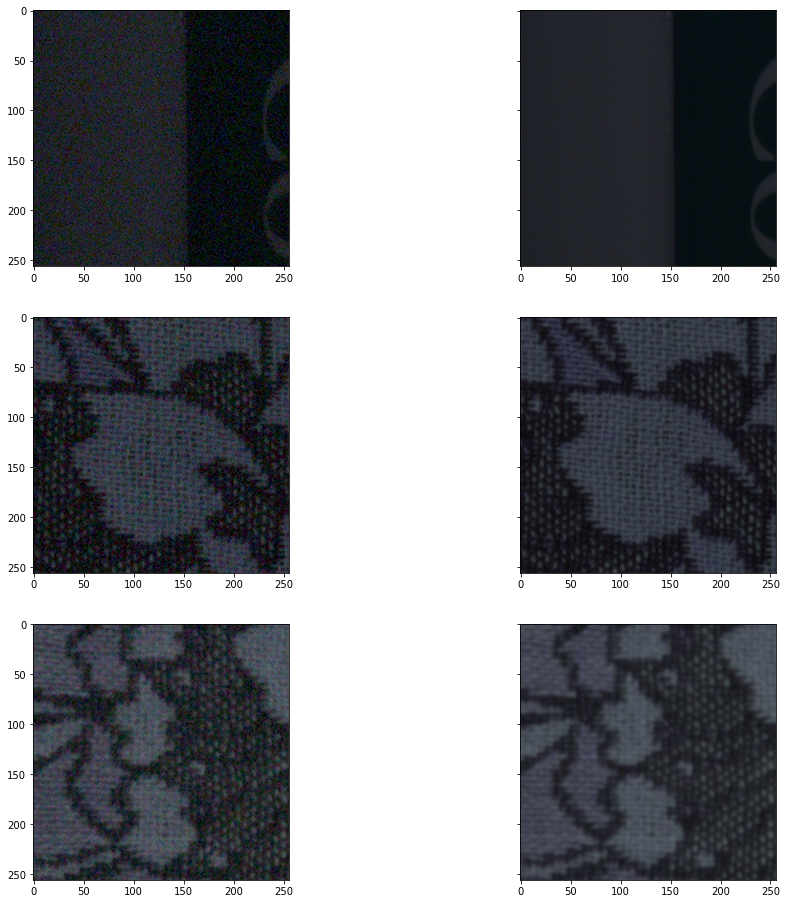

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get dataset items
test_index = 1

# plot images
X, y = dataset.__getitem__(0)
fig, axs = plt.subplots(3, 2, figsize=(16, 16), sharey=True)
axs[0, 0].imshow(X.permute(1, 2, 0))
axs[0, 1].imshow(y.permute(1, 2, 0))

X, y = dataset.__getitem__(10)
axs[1, 0].imshow(X.permute(1, 2, 0))
axs[1, 1].imshow(y.permute(1, 2, 0))

X, y = dataset.__getitem__(20)
axs[2, 0].imshow(X.permute(1, 2, 0))
axs[2, 1].imshow(y.permute(1, 2, 0))

###Split dataset into train, val, test split

In [14]:
# perform random splits on dataset to return train, val, test sets (manual seed fixes output for repeatable results , remove device = cuda for non. GPU )
dataset_length = len(dataset)

# set sizes
train_set_size = 0.8
val_set_size = 0.1
test_set_size = 0.1

# return lengths
train_set_length = round(train_set_size * dataset_length, 0)
val_set_length = round(val_set_size * dataset_length, 0)
test_set_length = dataset_length - train_set_length - val_set_length

# check
total = train_set_length + val_set_length + test_set_length
print(f'total length: {total} / train set length: {train_set_length} / validation set length: {val_set_length} / test set length: {test_set_length}')
assert total == dataset_length


total length: 160.0 / train set length: 128.0 / validation set length: 16.0 / test set length: 16.0


In [15]:
# create datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [int(train_set_length), int(val_set_length), int(test_set_length)],
    generator=torch.Generator().manual_seed(42)
)

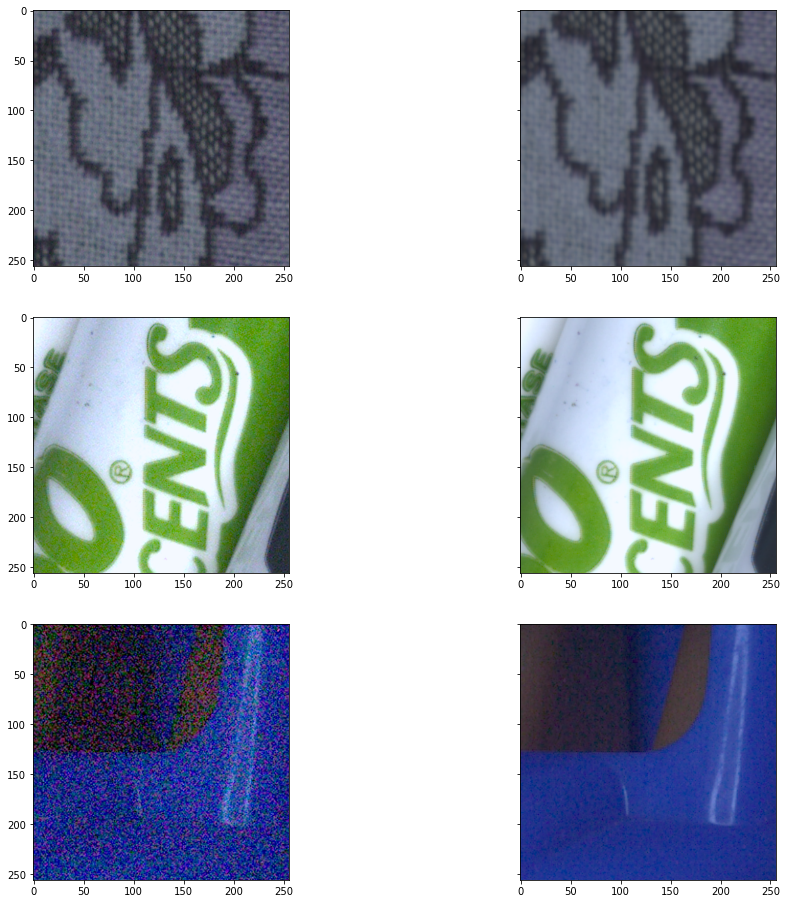

In [16]:
# Get dataset items
test_index = 1
X_train, y_train = train_dataset.__getitem__(test_index)
X_val, y_val = val_dataset.__getitem__(test_index)
X_test, y_test = test_dataset.__getitem__(test_index)
 
# plot images
fig, axs = plt.subplots(3, 2, figsize=(16, 16), sharey=True)
axs[0, 0].imshow(X_train.permute(1, 2, 0))
axs[0, 1].imshow(y_train.permute(1, 2, 0))
axs[1, 0].imshow(X_val.permute(1, 2, 0))
axs[1, 1].imshow(y_val.permute(1, 2, 0))
axs[2, 0].imshow(X_test.permute(1, 2, 0))
axs[2, 1].imshow(y_test.permute(1, 2, 0))

##Set hyper parameters

In [17]:
# define hyper parameters
plot_itterations = 1
num_epoch = 2
batch = 8
max_itterations = 4e5
initial_learning_rate = 2e-4
min_learning_rate = 1e-7

##Create dataloader

In [18]:
# create dataloader
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=False, num_workers=4)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=batch, shuffle=False, num_workers=4)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False, num_workers=4)
 
# set up a dictionary of dataloaders for train and val
dataloader = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}
 
 
dataset_sizes = {'train': len(train_dataloader), 'val': len(val_dataloader), 'test': len(test_dataloader)}
 
print(dataset_sizes)

{'train': 16, 'val': 2, 'test': 2}


In [19]:
# check make up of dataloader
 
dataiter = iter(train_dataloader)
image_example, label_example = dataiter.next()  # -> [batch, channels, height, width]
print(image_example.shape)
print(torch.min(image_example), torch.max(image_example))

torch.Size([8, 3, 256, 256])
tensor(0.) tensor(1.)


In [20]:
import torchvision 
 
# create tensorboard img grid for train images
img_grid_noisy = torchvision.utils.make_grid(image_example)
writer.add_image('Noisy Images', img_grid_noisy)
# create tensorboard img grid for test
img_grid_GT = torchvision.utils.make_grid(label_example)
writer.add_image('Ground Truth Images', img_grid_GT)
writer.close()

##Define model

###Note for transfer learning and importing pre-trained models

In [21]:
''' 
Models can be imported from saved files and transfer learned by:
 
'''
#from torchvision import models
 
#model = models.resnet101(pretrained=True)
 
# TO ONLY TRAIN THE LAST LAYER (TRANSFER LEARNING) DO THE FOLLOWING
#for param in model.parameters():
#   param.requires_grad = False  # freezes all layers in beginning
 
# return number of features in output (to transfer learn)
#num_ftrs = model.fc.in_features
 
# set output fully connected using
#model.fc = nn.Linear(num_ftrs, 2)   # (input layers, output layers)
#model.to(device)

' \nModels can be imported from saved files and transfer learned by:\n \n'

###Build model

In [22]:
#basic test model

# import torch.nn as nn
# import torch.nn.functional as F
 
 
# class autoencoder(nn.Module):
#     def __init__(self):
#       super(autoencoder, self).__init__()
#       self.encoder = nn.Sequential(
#             nn.Conv2d(3, 6, kernel_size=5),
#             nn.LeakyReLU(),
#             nn.Conv2d(6, 16, kernel_size=5),
#             nn.LeakyReLU(),
#             nn.Conv2d(16, 32, kernel_size=5),
#             nn.LeakyReLU()
#       )
#       self.decoder = nn.Sequential(   
#           nn.ConvTranspose2d(32, 16,kernel_size=5),
#           nn.LeakyReLU(),          
#           nn.ConvTranspose2d(16, 6,kernel_size=5),
#           nn.LeakyReLU(),
#           nn.ConvTranspose2d(6, 3,kernel_size=5),
#           nn.Sigmoid(),
#       )
        
#     def forward(self, x):
#       encoded = self.encoder(x)
#       decoded = self.decoder(encoded)
#       return decoded
 

In [23]:
'''
HINet: Half Instance Normalization Network for Image Restoration
@inproceedings{chen2021hinet,
  title={HINet: Half Instance Normalization Network for Image Restoration},
  author={Liangyu Chen and Xin Lu and Jie Zhang and Xiaojie Chu and Chengpeng Chen},
  booktitle={IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops},
  year={2021}
}
'''

import torch
import torch.nn as nn

def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer

def conv_down(in_chn, out_chn, bias=False):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=4, stride=2, padding=1, bias=bias)
    return layer

def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)

## Supervised Attention Module
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size=3, bias=True):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

class HINet(nn.Module):

    def __init__(self, in_chn=3, wf=64, depth=5, relu_slope=0.2, hin_position_left=0, hin_position_right=4):
        super(HINet, self).__init__()
        self.depth = depth
        self.down_path_1 = nn.ModuleList()
        self.down_path_2 = nn.ModuleList()
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)
        self.conv_02 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        prev_channels = self.get_input_chn(wf)
        for i in range(depth): #0,1,2,3,4
            use_HIN = True if hin_position_left <= i and i <= hin_position_right else False
            downsample = True if (i+1) < depth else False
            self.down_path_1.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, use_HIN=use_HIN))
            self.down_path_2.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, use_csff=downsample, use_HIN=use_HIN))
            prev_channels = (2**i) * wf

        self.up_path_1 = nn.ModuleList()
        self.up_path_2 = nn.ModuleList()
        self.skip_conv_1 = nn.ModuleList()
        self.skip_conv_2 = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path_1.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.up_path_2.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.skip_conv_1.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            self.skip_conv_2.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            prev_channels = (2**i)*wf
        self.sam12 = SAM(prev_channels)
        self.cat12 = nn.Conv2d(prev_channels*2, prev_channels, 1, 1, 0)

        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        image = x
        #stage 1
        x1 = self.conv_01(image)
        encs = []
        decs = []
        for i, down in enumerate(self.down_path_1):
            if (i+1) < self.depth:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                x1 = down(x1)

        for i, up in enumerate(self.up_path_1):
            x1 = up(x1, self.skip_conv_1[i](encs[-i-1]))
            decs.append(x1)

        sam_feature, out_1 = self.sam12(x1, image)
        #stage 2
        x2 = self.conv_02(image)
        x2 = self.cat12(torch.cat([x2, sam_feature], dim=1))
        blocks = []
        for i, down in enumerate(self.down_path_2):
            if (i+1) < self.depth:
                x2, x2_up = down(x2, encs[i], decs[-i-1])
                blocks.append(x2_up)
            else:
                x2 = down(x2)

        for i, up in enumerate(self.up_path_2):
            x2 = up(x2, self.skip_conv_2[i](blocks[-i-1]))

        out_2 = self.last(x2)
        out_2 = out_2 + image
        return [out_1, out_2]

    def get_input_chn(self, in_chn):
        return in_chn

    def _initialize(self):
        gain = nn.init.calculate_gain('leaky_relu', 0.20)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=gain)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample, relu_slope, use_csff=False, use_HIN=False):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.identity = nn.Conv2d(in_size, out_size, 1, 1, 0)
        self.use_csff = use_csff

        self.conv_1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_1 = nn.LeakyReLU(relu_slope, inplace=False)
        self.conv_2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_2 = nn.LeakyReLU(relu_slope, inplace=False)

        if downsample and use_csff:
            self.csff_enc = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.csff_dec = nn.Conv2d(out_size, out_size, 3, 1, 1)

        if use_HIN:
            self.norm = nn.InstanceNorm2d(out_size//2, affine=True)
        self.use_HIN = use_HIN

        if downsample:
            self.downsample = conv_down(out_size, out_size, bias=False)

    def forward(self, x, enc=None, dec=None):
        out = self.conv_1(x)

        if self.use_HIN:
            out_1, out_2 = torch.chunk(out, 2, dim=1)
            out = torch.cat([self.norm(out_1), out_2], dim=1)
        out = self.relu_1(out)
        out = self.relu_2(self.conv_2(out))

        out += self.identity(x)
        if enc is not None and dec is not None:
            assert self.use_csff
            out = out + self.csff_enc(enc) + self.csff_dec(dec)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, relu_slope):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.conv_block = UNetConvBlock(in_size, out_size, False, relu_slope)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], 1)
        out = self.conv_block(out)
        return out

class Subspace(nn.Module):

    def __init__(self, in_size, out_size):
        super(Subspace, self).__init__()
        self.blocks = nn.ModuleList()
        self.blocks.append(UNetConvBlock(in_size, out_size, False, 0.2))
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, bias=True)

    def forward(self, x):
        sc = self.shortcut(x)
        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        return x + sc


class skip_blocks(nn.Module):

    def __init__(self, in_size, out_size, repeat_num=1):
        super(skip_blocks, self).__init__()
        self.blocks = nn.ModuleList()
        self.re_num = repeat_num
        mid_c = 128
        self.blocks.append(UNetConvBlock(in_size, mid_c, False, 0.2))
        for i in range(self.re_num - 2):
            self.blocks.append(UNetConvBlock(mid_c, mid_c, False, 0.2))
        self.blocks.append(UNetConvBlock(mid_c, out_size, False, 0.2))
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, bias=True)

    def forward(self, x):
        sc = self.shortcut(x)
        for m in self.blocks:
            x = m(x)
        return x + sc

###Define loss, optimizer and extras (scheduler etc)

####Custom Peak Signal To Noise Loss Function 

In [24]:
# create custom PSNRLoss class - taken from https://github.com/photosynthesis-team/piq

class PSNRLoss(nn.Module):

  def __init__(self):
    super(PSNRLoss, self).__init__()

  def forward(self, R, X, y, data_range=1.0, reduction='mean', convert_to_greyscale=False):
      r"""Compute Peak Signal-to-Noise Ratio for a batch of images.
      Supports both greyscale and color images with RGB channel order.
      Args:
          R: An input tensor. Shape :math:`(2, N, C, H, W)`.  where position 0 is [stage1 output, stage 2 output] -> outputs from model
          x: An input tensor. Shape :math:`(N, C, H, W)`.
          y: A target tensor. Shape :math:`(N, C, H, W)`.
          data_range: Maximum value range of images (usually 1.0 or 255).
          reduction: Specifies the reduction type:
              ``'none'`` | ``'mean'`` | ``'sum'``. Default: ``'mean'``
          convert_to_greyscale: Convert RGB image to YCbCr format and computes PSNR
              only on luminance channel if `True`. Compute on all 3 channels otherwise.
      Returns:
          PSNR Index of similarity betwen two images.
      References:
          https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
      """
      # Constant for numerical stability
      EPS = 1e-8

      X = X / float(data_range)
      y = y / float(data_range)
      R[0] = R[0] / float(data_range)
      R[1] = R[1] / float(data_range)
      

      if (X.size(1) == 3) and convert_to_greyscale:
          # Convert RGB image to YCbCr and take luminance: Y = 0.299 R + 0.587 G + 0.114 B
          rgb_to_grey = torch.tensor([0.299, 0.587, 0.114]).view(1, -1, 1, 1).to(X)
          R[0] = torch.sum(R[0] * rgb_to_grey, dim=1, keepdim=True)
          R[1] = torch.sum(R[1] * rgb_to_grey, dim=1, keepdim=True)
          X = torch.sum(X * rgb_to_grey, dim=1, keepdim=True)
          y = torch.sum(y * rgb_to_grey, dim=1, keepdim=True)

      score = []
      for i in range(0, len(R)):
        mse = torch.mean(((R[i].add(X)) - y) ** 2, dim=[1, 2, 3])
        max_value = 1. if X[0].max() <= 1 else 255. # max pixel value
        score.append(20. * torch.log10(max_value / torch.sqrt(mse)))

      summed_loss = score[0].add(score[1])
      summed_loss = -1. * summed_loss

      return _reduced(summed_loss, reduction) # reduced to single value

    
def _reduced(loss, reduction_type):
  r"""Reduce input in batch dimension if needed.
  Args:
      x: Tensor with shape (N, *).
      reduction: Specifies the reduction type:
          ``'none'`` | ``'mean'`` | ``'sum'``. Default: ``'mean'``
  """
  if reduction_type == 'none':
      return loss
  elif reduction_type == 'mean':
      return loss.mean(dim=0)
  elif reduction_type == 'sum':
      return loss.sum(dim=0)
  else:
      raise ValueError("Uknown reduction. Expected one of {'none', 'mean', 'sum'}")



In [25]:
from torch import optim
from torch.optim import lr_scheduler
 
model = HINet().to(device)  # gpu
# set loss and optimizer functions
criterion = PSNRLoss().to(device)  # custom loss
optimizer = torch.optim.Adam(model.parameters(), lr=initial_learning_rate)
 
#scheduler 
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # every stepsize epochs (e.g. 5) the learning rate is multiplied by gamma
ca_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_itterations, eta_min=min_learning_rate, last_epoch=-1, verbose=False)

In [26]:
# tensorboard
writer.add_graph(model, image_example.to(device, dtype=torch.float))
writer.close()

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:959: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


##Training Loop

In [27]:
import time
import copy
from tqdm import tqdm
 
# training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, plot_itter=2):
  since = time.time()
  print('Beginning...')

  output_dict = {'epoch': [], 'images': [], 'labels': [], 'outputs': [], 'loss': [], 'learning rate': [initial_learning_rate]}
  num_itters = 0
  # load existing best weights and reset accuracy
  best_model_wts = copy.deepcopy(model.state_dict())
  
  for epoch in range(num_epochs):
    if num_itters <= max_itterations:

      print(f'\nEpoch {epoch + 1} / {num_epochs}')
      print('-' * 10)
      epoch_loss_cache = {'train': 0, 'val': 0}  # for tensorboard
      # each epoch has training and validation phase
      for phase in ['train', 'val']:
        
        if phase == 'train':
          print('Training...')
          model.train()  # set to training mode
        else:
          print('Evaluating...')
          model.eval()  # set to evaluation mode
          best_loss = 1e5  # large so always saves best loss
  
        # set vals
        running_loss = 0 
  
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader[phase])):
          # send to gpu
          images = images.to(device, dtype=torch.float)  # -> [batch, channels, height, width]
          labels = labels.to(device, dtype=torch.float) # -> [batch, channels, height, width]
  
          # forward pass
          # track history if only in train
          with torch.set_grad_enabled(phase=='train'):
            outputs = model(images) # -> [batch, channels, height, width] -> outputs is [out_1 (STAGE 1 output image), out_2 (STAGE 2 output image)]
            # # plot output for reference
            # fig, axs = plt.subplots(1, 2, figsize=(16, 16), sharey=True)
            # axs[0].imshow(images[0].detach().permute(1, 2, 0).to('cpu'))
            # axs[1].imshow(outputs[1][1].detach().permute(1, 2, 0).to('cpu'))
            # plt.show()
            loss = criterion(outputs, images, labels, data_range=1.0, reduction='mean')           
            num_itters += 1
  
            # backward pass only if in training
            if phase == 'train':
              optimizer.zero_grad()  # emptys cache
              loss.backward()
              optimizer.step()
              num_itters += 1

          # save for plotting    
          if epoch % plot_itter == 0 and batch_idx == 0 and phase == 'val':  # every Xth val epoch save data for plotting
            output_dict['epoch'].append(epoch)
            output_dict['images'].append(images)
            output_dict['labels'].append(labels)
            output_dict['outputs'].append(outputs)
  
          # statistics
          running_loss += loss.item() * images.size(0)  # mult by batch to allow avg (epoch loss) to be calcd.
        
        if phase == 'train':
          scheduler.step()
          output_dict['learning rate'].append(scheduler.get_last_lr())
          # plot learning rate
          writer.add_scalar(f'Learning rate', 
                            np.array(output_dict['learning rate'][-1]), 
                            epoch) 
    
        epoch_loss = running_loss / dataset_sizes[phase]  # average of epoch losses
        epoch_loss_cache[phase] = epoch_loss
          
        print(f'{phase} Loss: {epoch_loss:.4f}\n') 
  
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss: 
          best_loss = epoch_loss
          best_loss_epoch = epoch
          best_model_wts = copy.deepcopy(model.state_dict())

          if epoch % plot_itter == 0 and batch_idx == 0:  # every Xth val epoch save data for plotting
            output_dict['loss'].append(epoch_loss)
      # save train and val epoch loss to tensorboard
      writer.add_scalars(f'Train/Val loss', 
                        {'train': epoch_loss_cache['train'],
                        'val': epoch_loss_cache['val']}, 
                        epoch) 
      # append output for plotting
      
    # print epoch results
    time_elapsed = time.time() - since
    print(f'Epoch complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Epoch validation loss: {best_loss:.4f} @ epoch {best_loss_epoch}')
    print(f'Total itterations count: {num_itters}')

  # print training results
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

  return output_dict

## TRAIN!

In [ ]:
# perform training and evaluating
output_dict = train_model(model, criterion, optimizer, ca_lr_scheduler, num_epochs=num_epoch, plot_itter=plot_itterations)

Beginning...

Epoch 1 / 2
----------
Training...


  0%|          | 0/16 [00:00<?, ?it/s]

loss: -15.532411575317383
loss shape: <built-in method size of Tensor object at 0x7f18c95bb5f0>


  6%|▋         | 1/16 [00:03<00:52,  3.48s/it]

loss: -26.155113220214844
loss shape: <built-in method size of Tensor object at 0x7f18c97ae5f0>


 12%|█▎        | 2/16 [00:04<00:27,  1.96s/it]

loss: -31.1253604888916
loss shape: <built-in method size of Tensor object at 0x7f18c96b30f0>


 19%|█▉        | 3/16 [00:05<00:19,  1.48s/it]

loss: -29.337129592895508
loss shape: <built-in method size of Tensor object at 0x7f18f82e2460>


 25%|██▌       | 4/16 [00:06<00:15,  1.25s/it]

In [ ]:
# write function to plot figure of input v output to tensorboard
def plot_output_comparison(output_dict, batch_size):
    '''
    Generates matplotlib Figure using a trained network, along with images
    from a batch
    '''
    # output list shape -> [(epoch, item, batch)]
    columns = ['noisy', 'ground truth']
 
    # append epochs to noisy and ground truth list - e.g. noisy, ground truth, epoch 1, epoch 2, ...
    [columns.append(f'Epoch {epoch+1}') for epoch in output_dict['epoch']]
 
    # plot the images from X input (noisy), y output (GT) and acorss the epochs for the entire batch
    fig, axs = plt.subplots(batch, len(columns), figsize=(16, 16), sharey=True)
 
    for i in range(0, batch):  # rows
      epoch_number = 0 
      for j in range(0, len(columns)):  # columns
        if i == 0:
          # create column labels
          axs[i, j].set_title(f'{columns[j]}')
        if j == 0:
          # create row labels
          axs[i, j].set_ylabel(f'Image\nbatch\n{i+1}', rotation=0, size='large', labelpad=50)
 
        # plot all epochs of image batch set
        if j == 0:
          axs[i, j].imshow(output_dict['images'][0][i].permute(1, 2, 0).to('cpu'))  # -> [dictionary][image types][batch]
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
        elif j == 1:
          axs[i, j].imshow(output_dict['labels'][0][i].permute(1, 2, 0).to('cpu'))
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
        else:
          #axs[i, j].imshow(output_dict['outputs'][i].permute(1, 2, 0).to('cpu'))
          axs[i, j].imshow(output_dict['outputs'][j-2][1].detach()[i].permute(1, 2, 0).to('cpu').numpy())
          axs[i, j].set_xticks([])
          axs[i, j].set_yticks([])
          #axs[i, j].set_title(label=f'Loss: {output_dict['loss'][epoch_number]}')
          epoch_number += 1
 
    fig.subplots_adjust(hspace=0, wspace=0)
 
    return fig

In [ ]:
# plot output list to tensorboard
fig = plot_output_comparison(output_dict, batch)
plt.show()

In [ ]:
%tensorboard --logdir=runs

##Test

In [ ]:
with torch.no_grad(): # stops computation of grads (speeds up)
  running_loss = 0

  for images, labels in tqdm(dataloader['test']):
 
    # send to gpu
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)
    outputs = model(images).to(device)

    # determine loss
    loss = criterion(outputs, images, labels, data_range=1.0)
    running_loss += loss.item()

  total_loss = running_loss / dataset_sizes['test']

  print(f'\nLoss of the network: {loss}')

##Save model weights and bias

In [ ]:
# save model state dict
PATH = f'/content/gdrive/MyDrive/Programming/models/{project_name}'

torch.save(model.state_dict(), PATH)